# Import libraries

In [64]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy

from collections import defaultdict
from sklearn.metrics import confusion_matrix
#from scikitplot.metrics import plot_roc

from sklearn.model_selection import train_test_split, cross_val_score 
from sklearn.metrics import accuracy_score, f1_score, classification_report
from sklearn.metrics import RocCurveDisplay, auc, roc_auc_score
from sklearn.metrics import make_scorer, accuracy_score, f1_score, classification_report
from sklearn.metrics import roc_curve, auc, roc_auc_score, precision_recall_curve
from sklearn.metrics import confusion_matrix

from sklearn.datasets import make_classification
from sklearn.preprocessing import label_binarize

from yellowbrick.classifier import ROCAUC



In [20]:
import scipy

# Prep Data

In [36]:
def load_npy(filename):
    return np.load(filename)


In [37]:
# reload 
X_y_ids = load_npy(f"Output_Saved/X_y_ids.npz") 
X, y, ids = X_y_ids['arr_0'], X_y_ids['arr_1'], X_y_ids['arr_2']

In [38]:
X = X.squeeze()
X.shape

(10000, 1280)

In [39]:
def moving_average_smoothing(series, window_size):
    """
    Perform moving average smoothing on a single time series.
    
    series: Input time series as a 1-dimensional numpy array.
    window_size: Size of the moving window as an integer.
    
    Returns the smoothed time series.
    """
    window = np.ones(window_size) / window_size
    smoothed_series = np.convolve(series, window, mode='same')
    return smoothed_series

w = 10

for i,time_series in enumerate(X):
    X[i]= moving_average_smoothing(X[i], w)

X

array([[ 464.38378357,  588.41712871,  730.78456307, ..., 1121.54020569,
         993.57362573,  857.56795231],
       [1536.54893036, 1801.66361832, 2051.19784009, ..., 1438.90477859,
        1119.8011977 ,  836.70870164],
       [1091.862005  , 1332.62366156, 1554.36918515, ..., 2703.78425184,
        2381.57394897, 2051.25514757],
       ...,
       [1439.27952856, 1798.35439468, 2137.46808138, ..., 3210.70632654,
        2642.64219789, 2256.21887327],
       [ 792.80298301,  981.73775366, 1151.86570419, ..., 1341.22718811,
        1134.71273879,  933.90420096],
       [ 920.051894  , 1168.70717995, 1500.46220581, ..., 2004.17564244,
        1798.81123347, 1580.41434133]])

In [40]:
from tslearn.preprocessing import TimeSeriesScalerMeanVariance


X = TimeSeriesScalerMeanVariance().fit_transform(X)
print(X.shape)
X = X.squeeze()
print(X.shape)


(10000, 1280, 1)
(10000, 1280)


In [41]:
df = pd.DataFrame(np.squeeze(X))
df["genre"] = y

In [42]:
# Assegna la variabile target
y = df.iloc[:, -1].values

# Assegna il resto dei valori a X escludendo l'ultima colonna
X = df.iloc[:, :-1].values
X.shape, y.shape

((10000, 1280), (10000,))

In [43]:
from pyts.approximation import PiecewiseAggregateApproximation
from tslearn.piecewise import SymbolicAggregateApproximation
from pyts.approximation import DiscreteFourierTransform

print(X.shape)
window_size = 4
paa = PiecewiseAggregateApproximation(window_size=window_size)
X_paa = paa.transform(X)
print(X_paa.shape)


(10000, 1280)
(10000, 320)


In [44]:
X_paa.shape, y.shape

((10000, 320), (10000,))

In [65]:
classes = df['genre'].unique()

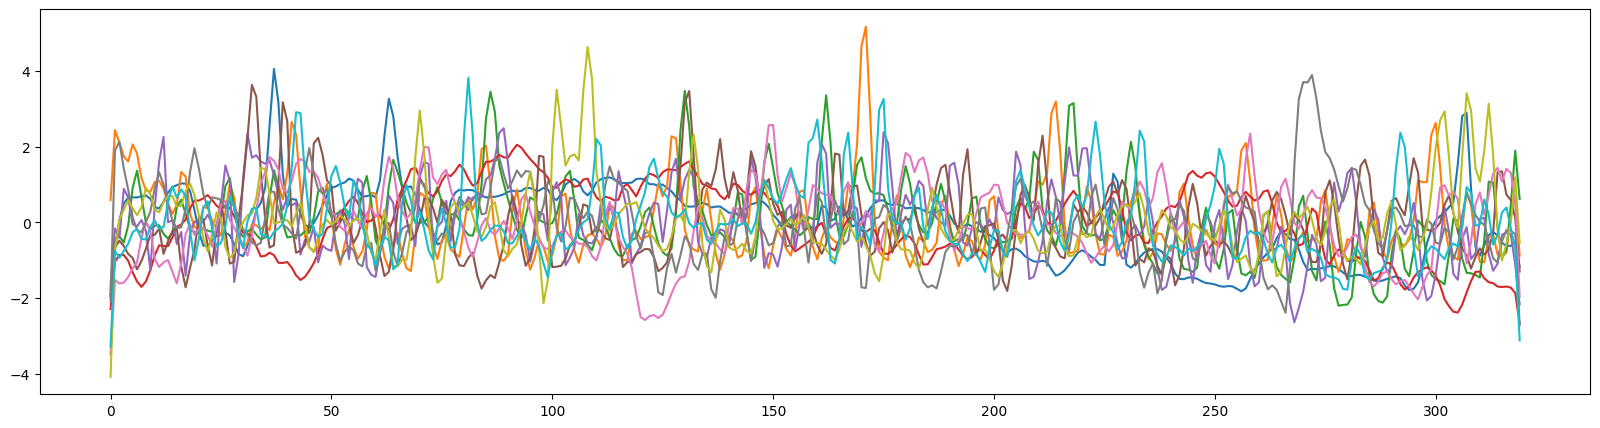

In [45]:
# plot the audio wave
plt.figure(figsize=(20,5))

for ts in X_paa[:10]:
  plt.plot(ts)

plt.show()

## Split Data

In [46]:
X_train, X_test, y_train, y_test = train_test_split(
    X_paa, y, test_size=0.2, random_state=42, stratify=y
)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((8000, 320), (2000, 320), (8000,), (2000,))

# Dummy Classifier

In [14]:
from sklearn.dummy import DummyClassifier

dummy_clf = DummyClassifier()
dummy_clf.fit(X_train, y_train)

y_pred=dummy_clf.predict(X_test)

print('Accuracy %s' % accuracy_score(y_test, y_pred))
print('F1-score %s' % f1_score(y_test, y_pred, average=None))
print(classification_report(y_test, y_pred))

Accuracy 0.05
F1-score [0.0952381 0.        0.        0.        0.        0.        0.
 0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.        0.        0.        0.       ]
                   precision    recall  f1-score   support

              emo       0.05      1.00      0.10       100
             folk       0.00      0.00      0.00       100
             goth       0.00      0.00      0.00       100
            happy       0.00      0.00      0.00       100
      heavy-metal       0.00      0.00      0.00       100
       honky-tonk       0.00      0.00      0.00       100
           j-idol       0.00      0.00      0.00       100
             kids       0.00      0.00      0.00       100
   minimal-techno       0.00      0.00      0.00       100
              mpb       0.00      0.00      0.00       100
          new-age       0.00      0.00      0.00       100
            opera       0.00      0.00      0.00       100
            piano  

/Users/daviderizzello/Documents/UNIPI/Data_Mining/Progetto_DM2/DM2_UNIPI_Prj/env/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/daviderizzello/Documents/UNIPI/Data_Mining/Progetto_DM2/DM2_UNIPI_Prj/env/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/daviderizzello/Documents/UNIPI/Data_Mining/Progetto_DM2/DM2_UNIPI_Prj/env/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in la

In [15]:
X_train.shape, y_train.shape

((8000, 320), (8000,))

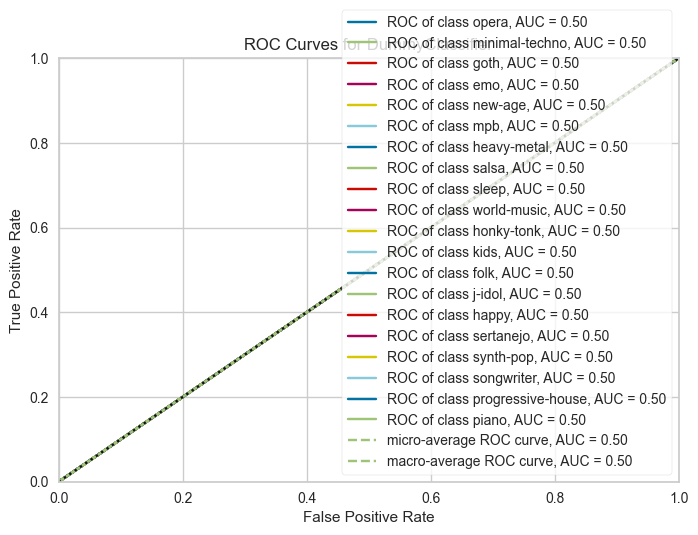

<Axes: title={'center': 'ROC Curves for DummyClassifier'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

In [66]:
visualizer = ROCAUC(dummy_clf, classes=classes)
# Fit the training data to the visualizer
visualizer.fit(X_train, y_train)

# Score the test data
visualizer.score(X_test, y_test)

# Render the ROC curve
visualizer.show()

# Shapelets Transform

In [47]:
from keras.optimizers import Adagrad
from tslearn.shapelets import ShapeletModel
from tslearn.shapelets import grabocka_params_to_shapelet_size_dict

In [48]:
# numero ts and grandezza come quella di X train
n_ts, ts_sz = X_train.shape
# numero di classi, quelle della variabile target emotion
n_classes = len(set(y_train))

# Set the number of shapelets per size as done in the original paper
shapelet_sizes = grabocka_params_to_shapelet_size_dict(n_ts=n_ts,
                                                       ts_sz=ts_sz,
                                                       n_classes=n_classes,
                                                       l= 0.1,
                                                       r= 1)

print('n_ts', n_ts)
print('ts_sz', ts_sz)
print('n_classes', n_classes)
print('shapelet_sizes', shapelet_sizes)


n_ts 8000
ts_sz 320
n_classes 20
shapelet_sizes {32: 7}


In [31]:
from sklearn.model_selection import GridSearchCV
from tslearn.shapelets import ShapeletModel

# Definire i parametri da esplorare
param_grid = {
    'optimizer': ['sgd', 'adam'],
    'weight_regularizer': [0.01, 0.1],
    'max_iter': [100, 200],
}

# Inizializzare il classificatore Shapelet
shp_clf = ShapeletModel(n_shapelets_per_size=shapelet_sizes)

# Creare l'oggetto GridSearchCV
grid_search = GridSearchCV(shp_clf, param_grid, cv=3, scoring='accuracy')

# Eseguire la grid search sui dati di addestramento
grid_search.fit(X_train, y_train)

# Stampare i migliori parametri trovati
print("Migliori parametri:", grid_search.best_params_)

# Stampare l'accuratezza ottenuta con i migliori parametri
print("Accuratezza con migliori parametri:", grid_search.best_score_)


/Users/daviderizzello/Documents/UNIPI/Data_Mining/Progetto_DM2/DM2_UNIPI_Prj/env/lib/python3.11/site-packages/tslearn/shapelets/shapelets.py:354: FutureWarning: The default value for 'scale' is set to False in version 0.4 to ensure backward compatibility, but is likely to change in a future version.
  warnings.warn("The default value for 'scale' is set to False "
/Users/daviderizzello/Documents/UNIPI/Data_Mining/Progetto_DM2/DM2_UNIPI_Prj/env/lib/python3.11/site-packages/tslearn/shapelets/shapelets.py:354: FutureWarning: The default value for 'scale' is set to False in version 0.4 to ensure backward compatibility, but is likely to change in a future version.
  warnings.warn("The default value for 'scale' is set to False "
/Users/daviderizzello/Documents/UNIPI/Data_Mining/Progetto_DM2/DM2_UNIPI_Prj/env/lib/python3.11/site-packages/tslearn/shapelets/shapelets.py:354: FutureWarning: The default value for 'scale' is set to False in version 0.4 to ensure backward compatibility, but is likel

Migliori parametri: {'max_iter': 200, 'optimizer': 'adam', 'weight_regularizer': 0.1}
Accuratezza con migliori parametri: 0.14250047326229756


In [49]:
# Build the model based on what we established before   quali valori ??

#Define the model using parameters provided by the authors (except that we use fewer iterations here)
shp_clf = ShapeletModel(n_shapelets_per_size=shapelet_sizes,
                        optimizer="adam",
                        weight_regularizer=0.01,
                        max_iter=200,
                        verbose=1)

shp_clf


/Users/daviderizzello/Documents/UNIPI/Data_Mining/Progetto_DM2/DM2_UNIPI_Prj/env/lib/python3.11/site-packages/tslearn/shapelets/shapelets.py:354: FutureWarning: The default value for 'scale' is set to False in version 0.4 to ensure backward compatibility, but is likely to change in a future version.
  warnings.warn("The default value for 'scale' is set to False "


LearningShapelets(max_iter=200, n_shapelets_per_size={32: 7}, optimizer='adam',
                  verbose=1, weight_regularizer=0.01)

In [50]:
# Addestriamo il modello sugli shapelets estratti dal training set
shp_clf.fit(X_train, y_train)


Epoch 1/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - categorical_accuracy: 0.0378 - categorical_crossentropy: 3.0395 - loss: 3.1377
Epoch 2/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - categorical_accuracy: 0.0402 - categorical_crossentropy: 3.0234 - loss: 3.1070
Epoch 3/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - categorical_accuracy: 0.0393 - categorical_crossentropy: 3.0103 - loss: 3.0816
Epoch 4/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - categorical_accuracy: 0.0432 - categorical_crossentropy: 3.0042 - loss: 3.0650
Epoch 5/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - categorical_accuracy: 0.0497 - categorical_crossentropy: 2.9961 - loss: 3.0482
Epoch 6/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - categorical_accuracy: 0.0423 - categorical_crossentropy: 2.9946 - loss: 3.0393
Epoch 7/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - categorical_accuracy: 0.0548 - categorical_crossentropy: 2.9898 - loss: 3.0282
Epoch 8/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - categorical_acc

LearningShapelets(max_iter=200, n_shapelets_per_size={32: 7}, optimizer='adam',
                  verbose=1, weight_regularizer=0.01)

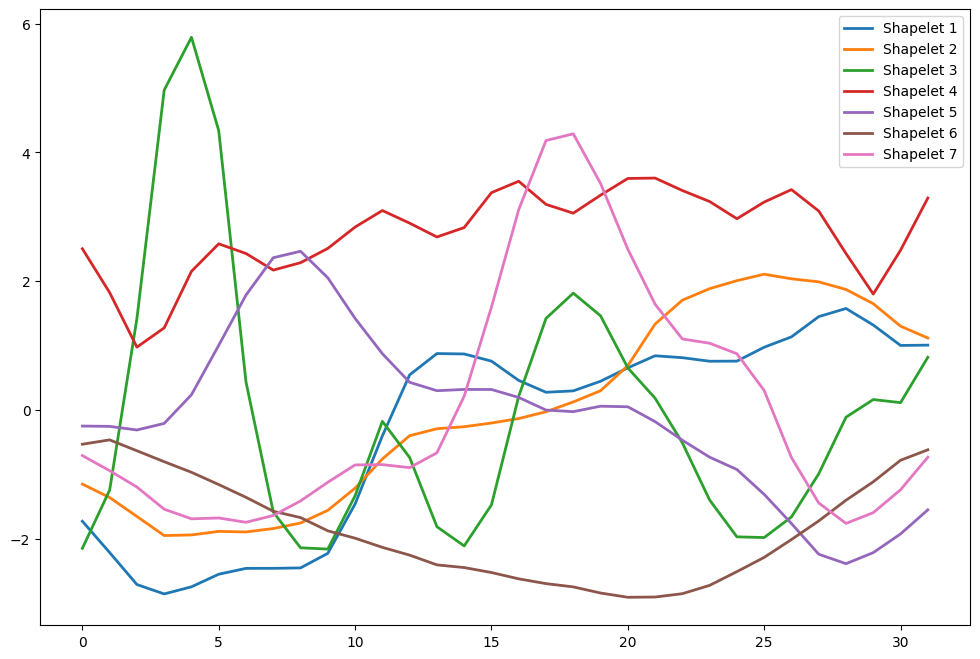

In [51]:
# Voglio visualizzare gli shapelets che sono venuti fuori 
shapelets = shp_clf.shapelets_
shapelets

# Visualize the shapelets
plt.figure(figsize=(12, 8))

# Plot each shapelet
for i, shapelet in enumerate(shapelets):
    plt.plot(shapelet.ravel(), label=f"Shapelet {i+1}", linewidth=2)

plt.legend()
#plt.title("7 Shapelets con lunghezza pari a 37")
plt.show()


In [67]:
#Utilizziamo gli shapelets addestrati per predire le etichette delle serie temporali nel test set
y_pred = shp_clf.predict(X_test)


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


In [53]:
# osserviamo ora i risultati
print('Accuracy %s' % accuracy_score(y_test, y_pred))
print('F1-score %s' % f1_score(y_test, y_pred, average='weighted'))
print(classification_report(y_test, y_pred))


Accuracy 0.135
F1-score 0.09173437776195131
                   precision    recall  f1-score   support

              emo       0.09      0.05      0.06       100
             folk       0.00      0.00      0.00       100
             goth       0.12      0.01      0.02       100
            happy       0.19      0.06      0.09       100
      heavy-metal       0.00      0.00      0.00       100
       honky-tonk       0.05      0.01      0.02       100
           j-idol       0.17      0.02      0.04       100
             kids       0.09      0.15      0.11       100
   minimal-techno       0.25      0.70      0.37       100
              mpb       0.07      0.10      0.08       100
          new-age       0.20      0.65      0.31       100
            opera       0.04      0.05      0.05       100
            piano       0.15      0.06      0.09       100
progressive-house       0.17      0.26      0.20       100
            salsa       0.00      0.00      0.00       100
        ser

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


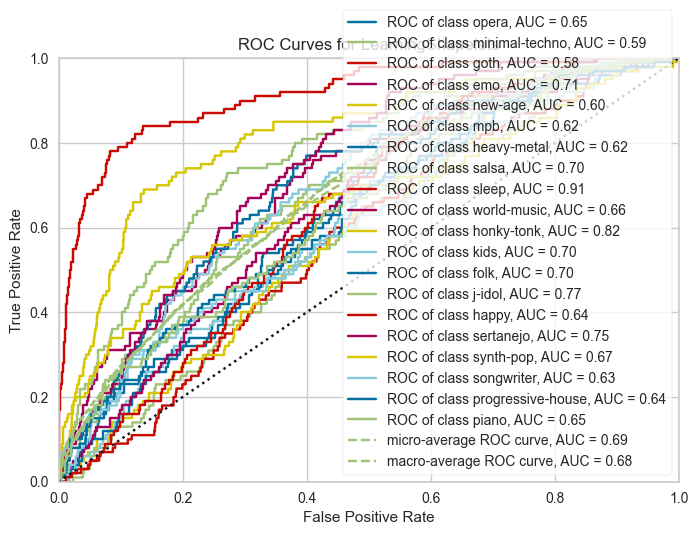

<Axes: title={'center': 'ROC Curves for LearningShapelets'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

In [69]:
# ROC Curve
visualizer = ROCAUC(shp_clf, classes=classes)
# Fit the training data to the visualizer
visualizer.fit(X_train, y_train)

# Score the test data
visualizer.score(X_test, y_test)

# Render the ROC curve
visualizer.show()

## Shapelets distance based classifier

In [54]:
#trasformo in shapelets il dataset di time series - TRAIN
X_train2 = shp_clf.transform(X_train)
X_train2.shape, X_train2


32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step


((8000, 7),
 array([[1.4739903 , 0.88975644, 1.9811261 , ..., 0.8201848 , 2.0021195 ,
         1.7633989 ],
        [1.119816  , 0.87248445, 3.168248  , ..., 0.5362259 , 1.8380108 ,
         1.7920554 ],
        [1.3323379 , 0.7742808 , 2.5182593 , ..., 0.72206354, 2.0335908 ,
         1.2523766 ],
        ...,
        [1.5261835 , 1.0454856 , 2.213616  , ..., 0.72520936, 2.2789738 ,
         1.5812516 ],
        [0.8617313 , 0.77636755, 2.0064046 , ..., 0.48916638, 2.0674655 ,
         1.9082799 ],
        [1.5731877 , 0.89305735, 2.170715  , ..., 0.8059206 , 1.402806  ,
         0.9928663 ]], dtype=float32))

In [55]:
#trasformo in shapelets il dataset di time series - TEST
X_test2 = shp_clf.transform(X_test)
X_test2.shape, X_test2


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


((2000, 7),
 array([[1.4883875 , 1.2355037 , 3.8523543 , ..., 1.2031658 , 2.508291  ,
         2.8986006 ],
        [1.4588197 , 1.0098226 , 2.5989149 , ..., 0.9513029 , 2.1262887 ,
         2.1385682 ],
        [1.6976286 , 1.5198553 , 2.999676  , ..., 1.3449856 , 2.035725  ,
         2.7277904 ],
        ...,
        [1.0294516 , 1.1614923 , 2.983174  , ..., 0.7916956 , 1.6371927 ,
         2.48249   ],
        [1.4325739 , 0.9545523 , 2.3762004 , ..., 0.52313733, 1.670605  ,
         2.1162672 ],
        [0.7753334 , 0.840693  , 2.5501528 , ..., 0.8065573 , 1.6135545 ,
         1.6254258 ]], dtype=float32))

In [56]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.neighbors import KNeighborsClassifier

#Facciamo una randomized search with 5-cross fold validation - caso knn con distanza manhattan/euclidea (che viene scelta nella cross validation)
param_dist = {
    'n_neighbors': (1, 3, 5, 7, 9, 10, 15, 30, 50),  # Number of neighbors
    'weights': ['uniform', 'distance'],  # Weight function used in prediction
    'p': [1, 2],  # Power parameter for the Minkowski metric (1: Manhattan distance, 2: Euclidean distance)
}

knn=KNeighborsClassifier()
random_search = RandomizedSearchCV(knn, param_distributions=param_dist, n_iter=10, cv=5, random_state=42)
random_search.fit(X_train2, y_train)
random_search.best_params_


{'weights': 'distance', 'p': 2, 'n_neighbors': 50}

In [57]:
from sklearn.neighbors import KNeighborsClassifier
# clf = KNeighborsClassifier(n_neighbors=5, weights='uniform', metric='euclidean') -->base di guidotti 
clf = KNeighborsClassifier(n_neighbors=50, weights='distance', p=2,  metric='euclidean', n_jobs=-1) # --> quello che viene fuori dalla randomized_search()
clf.fit(X_train2, y_train)

y_pred = clf.predict(X_test2)

print('Accuracy %s' % accuracy_score(y_test, y_pred))
print('F1-score %s' % f1_score(y_test, y_pred, average='weighted'))
print(classification_report(y_test, y_pred))


Accuracy 0.162
F1-score 0.15829255815214094
                   precision    recall  f1-score   support

              emo       0.12      0.13      0.12       100
             folk       0.08      0.04      0.05       100
             goth       0.04      0.03      0.03       100
            happy       0.25      0.19      0.21       100
      heavy-metal       0.05      0.04      0.04       100
       honky-tonk       0.16      0.12      0.14       100
           j-idol       0.11      0.14      0.12       100
             kids       0.14      0.14      0.14       100
   minimal-techno       0.52      0.50      0.51       100
              mpb       0.09      0.08      0.09       100
          new-age       0.24      0.45      0.31       100
            opera       0.18      0.13      0.15       100
            piano       0.10      0.14      0.12       100
progressive-house       0.21      0.16      0.18       100
            salsa       0.07      0.10      0.08       100
        ser

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 


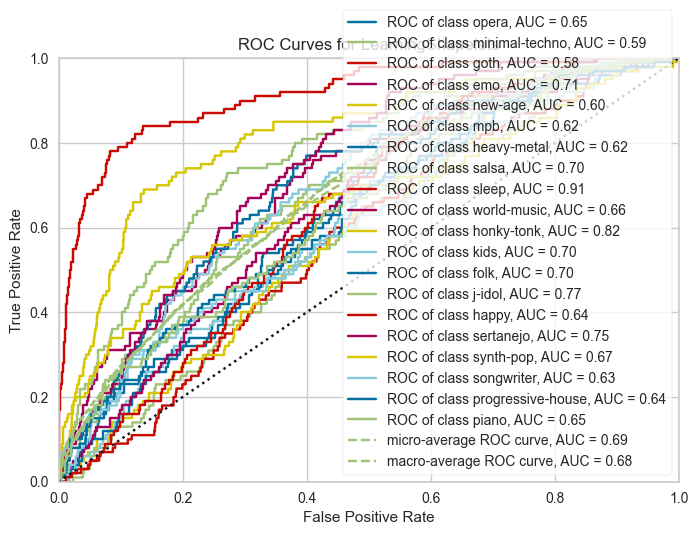

<Axes: title={'center': 'ROC Curves for LearningShapelets'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

In [63]:

y_score_shp_clf = shp_clf.predict_proba(X_test)

visualizer = ROCAUC(shp_clf, classes=classes)
# Fit the training data to the visualizer
visualizer.fit(X_train, y_train)

# Score the test data
visualizer.score(X_test, y_test)

# Render the ROC curve
visualizer.show()




In [61]:
classes

array(['opera', 'minimal-techno', 'goth', 'emo', 'new-age', 'mpb',
       'heavy-metal', 'salsa', 'sleep', 'world-music', 'honky-tonk',
       'kids', 'folk', 'j-idol', 'happy', 'sertanejo', 'synth-pop',
       'songwriter', 'progressive-house', 'piano'], dtype=object)